In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F

# MLP model

## Data preproc

In [2]:
words = open('names.txt', 'r').read().split()

In [114]:
char = sorted(list(set(''.join(words))))
stoi = dict()
nums = np.arange(len(char))

for l,num in zip(char, nums):
    stoi[l] = num+1

stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

In [99]:
# build dataset
def build_dataset(words):
    block_size = 3 # context lenght: how many characters de we take to predict the next one
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

X, Y = build_dataset(words)

print(X.shape, Y.shape)

torch.Size([228146, 3]) torch.Size([228146])


In [101]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:n1])
Xva, Yva = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [5]:
# CREATE EMBEDDINGS LAYER

C = torch.randn((27,2)) # 27 characters, 2 dimensions

emb = C[X] # for each example, we have 3 characters, and for each character we have 2 dimensions
print(emb.shape)

torch.Size([228146, 3, 2])


In [6]:
# CREATE FIRST HIDDEN LAYER

inputs = 3 * 2 # 3 characters, 2 dimensions
W1 = torch.randn(inputs,100) # set number of neurons in the hidden layer to 100
b1 = torch.randn(100)

print(W1.shape, b1.shape)

torch.Size([6, 100]) torch.Size([100])


We would like to do: 

$emb * W1 + b1$

But the dimension of W1 is (6,100) and of emb is (32, 3, 2)

To do this, we use the view() function to reshape emb. As long as the multiplication of dimensions equals the multiplications of dimensions of the original matrix, it works!

view() is more efficient than other methods because it doesn't do any operation. It just take the values in the computer and respecify how they are allocated

In [7]:
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)

# here the addition of b1 is broadcasted over the rows of the matrix. It works!
#   32, 100
# 1*32, 100

h.shape

torch.Size([228146, 100])

In [8]:
# CREATE OUTPUT LAYER

W2 = torch.randn(100, 27) # because output of last layer is 100, and we want to pred one of 27 characters
b2 = torch.randn(27) # one bias for each character

logits = h @ W2 + b2
counts = logits.exp()
probs = counts / counts.sum(-1, keepdim=True)

probs[0].sum() # should be 1

tensor(1.0000)

In [9]:
# LOSS FUNCTION

print(torch.arange(emb.shape[0])) # row iterator

print(Y) # target

probs[torch.arange(emb.shape[0]), Y] # current probabilities of the target character according to the model

tensor([     0,      1,      2,  ..., 228143, 228144, 228145])
tensor([ 5, 13, 13,  ..., 26, 24,  0])


tensor([2.2988e-07, 1.9791e-06, 1.7557e-15,  ..., 2.4603e-08, 3.3407e-10,
        1.3754e-11])

In [10]:
loss_manual = - probs[torch.arange(emb.shape[0]), Y].log().mean() # negative log likelihood
loss = F.cross_entropy(logits, Y) # same thing (more efficient: derive the softmax in the same step instead of each step)

round(loss_manual.item(), 3) == round(loss.item(), 3)

True

# Trainning

In [102]:
# set up parameters

C = torch.randn((27,2))
W1 = torch.randn(inputs,100)
b1 = torch.randn(100)
W2 = torch.randn(100, 27)
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [ ]:
# TRAINING
for epoch in range(100):
    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0],(32,)) # random batch of 32 samples of X

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss {loss.item()}')

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad

emb = C[Xte]
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
print(loss.item())

Epoch 0, Loss 19.17223358154297
Epoch 10, Loss 13.721491813659668
Epoch 20, Loss 9.688495635986328
Epoch 30, Loss 7.098658561706543
Epoch 40, Loss 5.983663558959961
Epoch 50, Loss 7.050439834594727
Epoch 60, Loss 3.968456268310547
Epoch 70, Loss 4.605628967285156
Epoch 80, Loss 3.431971788406372
Epoch 90, Loss 4.354269981384277
3.7743947505950928


# Tuning

In [82]:
# set up parameters

C = torch.randn((27,2))
W1 = torch.randn(inputs,100)
b1 = torch.randn(100)
W2 = torch.randn(100, 27)
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [ ]:
# HYPERPARAMETERS TUNING

lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre # from 0.001 to 1 in log scale to explore in a non-linear way

lri = []
losses = []

# TRAINING
for epoch in range(1000):
    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0],(32,)) # random batch of 32 samples of X

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss {loss.item()}')

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -lrs[epoch] * p.grad

    # track stats

    lri.append(lre[epoch])
    losses.append(loss.item())

emb = C[Xva]
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yva)
print(loss.item())

Epoch 0, Loss 14.48216724395752
Epoch 100, Loss 14.838695526123047
Epoch 200, Loss 10.637972831726074
Epoch 300, Loss 11.153177261352539
Epoch 400, Loss 8.539615631103516
Epoch 500, Loss 4.633828163146973
Epoch 600, Loss 3.0541675090789795
Epoch 700, Loss 3.16552472114563
Epoch 800, Loss 4.5675482749938965
Epoch 900, Loss 5.832299709320068
6.6695475578308105


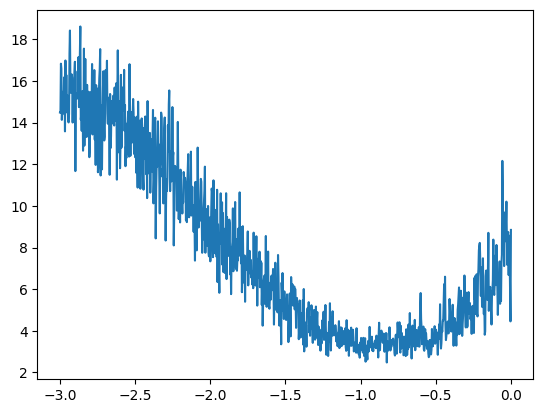

In [80]:
plt.plot(lri, losses);

Therefore, the best learning rate is in the range of 10e-1

In [104]:
# set up parameters

C = torch.randn((27,2))
W1 = torch.randn(inputs,100)
b1 = torch.randn(100)
W2 = torch.randn(100, 27)
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [ ]:
for epoch in range(1000):
    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0],(32,)) # random batch of 32 samples of X

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += - 0.1 * p.grad

emb = C[Xva]
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yva)
print(loss.item())

2.683300495147705


## Learning rate decay

In [ ]:
# do a learning rate decay for more 1000  epochs
for epoch in range(10000):
    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0],(32,)) # random batch of 32 samples of X

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += - 0.01 * p.grad

emb = C[Xva]
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yva)
print(loss.item())

2.5130152702331543


# Increase model

In [107]:
# set up parameters

C = torch.randn((27,2))
W1 = torch.randn(inputs,300)
b1 = torch.randn(300)
W2 = torch.randn(300, 27)
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [ ]:
for epoch in range(30000):
    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0],(64,)) # random batch of 64 samples of X

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += - 0.01 * p.grad

emb = C[Xva]
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yva)
print(loss.item())

2.364089250564575


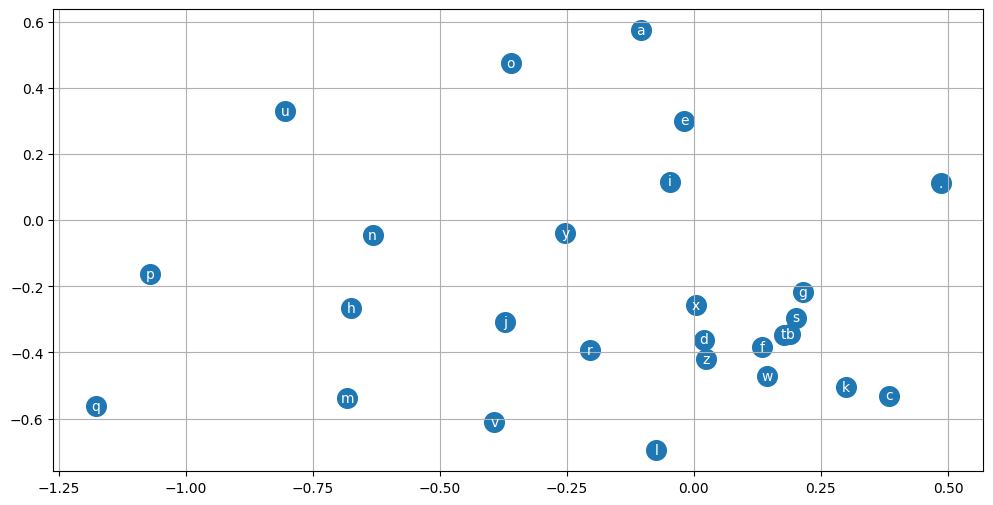

In [115]:
plt.figure(figsize=(12, 6))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha = "center", va = "center", color = "white")
plt.grid('minor')

We can see that the embedding learned some interesting things:
- vowels cluster together
- 'q' and '.' are alone (special characters)

To improve model, we would need to increase number of dimension in embeddings! But the model is already better (2.3) than bimodal one (2.5)

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * 3 # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mriahilynn.
meel.
neh.
callynn.
rulendrne.
cadeled.
elin.
maline.
leigin.
colaan.
ellyn.
lonilin.
sadbergohi.
jest.
jele.
jelinn.
bellan.
bemandi.
jylynn.
ele.


The model is starting to sound more like human NAMES!!!!